# Bandits

In this part, we will investigate the properties of the action selection schemes seen in the lecture and compare their properties:

1. greedy action selection
2. $\epsilon$-greedy action selection
3. softmax action selection

Let's re-use the definitions of the last exercise:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [2]:
class Bandit:
    """
    n-armed bandit.
    """
    def __init__(self, nb_actions, mean=0.0, std_Q=1.0, std_r=1.0):
        """
        :param nb_actions: number of arms.
        :param mean: mean of the normal distribution for $Q^*$.
        :param std_Q: standard deviation of the normal distribution for $Q^*$.
        :param std_r: standard deviation of the normal distribution for the sampled rewards.
        """
        # Store parameters
        self.nb_actions = nb_actions
        self.mean = mean
        self.std_Q = std_Q
        self.std_r = std_r
        
        # Initialize the true Q-values
        self.Q_star = rng.normal(self.mean, self.std_Q, self.nb_actions)
        
        # Optimal action
        self.a_star = self.Q_star.argmax()
        
    def step(self, action):
        """
        Sampled a single reward from the bandit.
        
        :param action: the selected action.
        :return: a reward.
        """
        return float(rng.normal(self.Q_star[action], self.std_r, 1)[0])

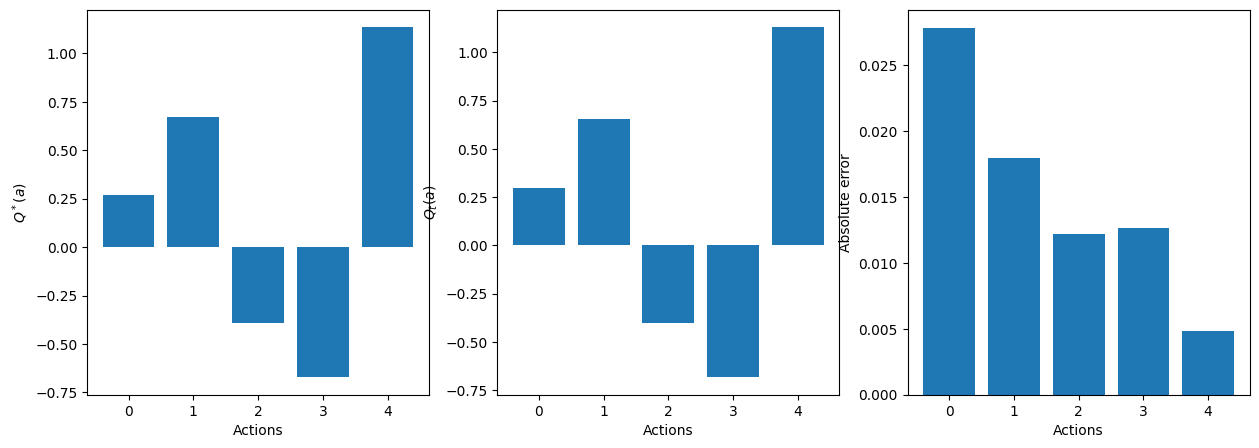

In [3]:
nb_actions = 5
bandit = Bandit(nb_actions)

all_rewards = []
for t in range(1000):
    rewards = []
    for a in range(nb_actions):
        rewards.append(bandit.step(a))
    all_rewards.append(rewards)
    
mean_reward = np.mean(all_rewards, axis=0)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.bar(range(nb_actions), bandit.Q_star)
plt.xlabel("Actions")
plt.ylabel("$Q^*(a)$")
plt.subplot(132)
plt.bar(range(nb_actions), mean_reward)
plt.xlabel("Actions")
plt.ylabel("$Q_t(a)$")
plt.subplot(133)
plt.bar(range(nb_actions), np.abs(bandit.Q_star - mean_reward))
plt.xlabel("Actions")
plt.ylabel("Absolute error")
plt.show()

## Greedy action selection

In **greedy action selection**, we systematically chose the action with the highest estimated Q-value at each play (or randomly when there are ties):

$$a_t = \text{argmax}_a Q_t(a)$$

We maintain estimates $Q_t$ of the action values (initialized to 0) using the online formula:

$$Q_{t+1}(a_t) = Q_t(a_t) + \alpha \, (r_{t} - Q_t(a_t))$$

when receiving the sampled reward $r_t$ after taking the action $a_t$. The learning rate $\alpha$ can be set to 0.1 at first.

The algorithm simply alternates between these two steps for 1000 plays (or steps): take an action, update its Q-value. 

**Q:** Implement the greedy algorithm on the 5-armed bandit.

Your algorithm will look like this:

* Create a 5-armed bandit (mean of zero, variance of 1).
* Initialize the estimated Q-values to 0 with an array of the same size as the bandit.
* **for** 1000 plays:
    * Select the greedy action $a_t^*$ using the current estimates.
    * Sample a reward from $\mathcal{N}(Q^*(a_t^*), 1)$.
    * Update the estimated Q-value of the action taken.
    
Additionally, you will store the received rewards at each step in an initially empty list or a numpy array of the correct size and plot it in the end. You will also plot the true Q-values and the estimated Q-values at the end of the 1000 plays. 

*Tip:* to implement the argmax, do not rely on `np.argmax()`. If there are ties in the array, for example at the beginning:

```python
x = np.array([0, 0, 0, 0, 0])
```

`x.argmax()` will return you the **first occurrence** of the maximum 0.0 of the array. In this case it will be the index 0, so you will always select the action 0 first. 

It is much more efficient to retrieve the indices of **all** maxima and randomly select one of them:

```python
a = rng.choice(np.where(x == x.max())[0])
```

`np.where(x == x.max())` returns a list of indices where `x` is maximum. `rng.choice()` randomly selects one of them.

**Q:** Re-run your algorithm multiple times with different values of $Q^*$ (simply recreate the `Bandit`) and observe:

1. How much reward you get.
2. How your estimated Q-values in the end differ from the true Q-values.
3. Whether greedy action action selection finds the optimal action or not.

Before going further, let's turn the agent into a class for better reusability. 

**Q:** Create a `GreedyAgent` class taking the bandit as an argument as well as the learning rate `alpha=0.1`:

```python
bandit = Bandit(nb_actions)

agent = GreedyAgent(bandit, alpha=0.1)
```

The constructor should initialize the array of estimated Q-values `Q_t` and store it as an attribute.

Define a method `act(self)` that returns the index of the greedy action based on the current estimates, as well as a method `update(self, action, reward)` that allows to update the estimated Q-value of the action given the obtained reward. Define also a `train(self, nb_steps)` method that implements the complete training process for `nb_steps=1000` plays and returns the list of obtained rewards.

```python
class GreedyAgent:
    def __init__(self, bandit, alpha):
        # TODO
        
    def act(self):      
        action = # TODO
        return action
        
    def update(self, action, reward):
        # TODO
        
    def train(self, nb_steps):
        # TODO
```

Re-run the experiment using this Greedy agent.

**Q:** Modify the `train()` method so that it also returns a list of binary values (0 and 1) indicating for each play whether the agent chose the optimal action. Plot this list and observe the lack of exploration.

*Hint:* the index of the optimal action is already stored in the bandit: `bandit.a_star`.

The evolution of the received rewards and optimal actions does not give a clear indication of the successful learning, as it is strongly dependent on the true Q-values. To truly estimate the performance of the algorithm, we have to average these results over many runs, e.g. 200.

**Q:** Run the learning procedure 200 times (new bandit and agent every time) and average the results. Give a unique name to these arrays (e.g. `rewards_greedy` and `optimal_greedy`) as we will do comparisons later. Compare the results with the lecture, where a 10-armed bandit was used.

## $\epsilon$-greedy action selection

The main drawback of greedy action selection is that it does not explore: as soon as it finds an action better than the others (with a sufficiently positive true Q-value, i.e. where the sampled rewards are mostly positive), it will keep selecting that action and avoid exploring the other options. 

The estimated Q-value of the selected action will end up being quite correct, but those of the other actions will stay at 0.

In $\epsilon$-greedy action selection, the greedy action $a_t^*$ (with the highest estimated Q-value) will be selected with a probability $1-\epsilon$, the others with a probability of $\epsilon$ altogether. 

$$
    \pi(a) = \begin{cases} 1 - \epsilon \; \text{if} \; a = a_t^* \\ \frac{\epsilon}{|\mathcal{A}| - 1} \; \text{otherwise.} \end{cases}
$$

If you have $|\mathcal{A}| = 5$ actions, the four non-greedy actions will be selected with a probability of $\frac{\epsilon}{4}$.

**Q:** Create a `EpsilonGreedyAgent` (possibly inheriting from `GreedyAgent` to reuse code) to implement $\epsilon$-greedy action selection (with $\epsilon=0.1$ at first). Do not overwrite the arrays previously calculated (mean reward and optimal actions), as you will want to compare the two methods in a single plot.

To implement $\epsilon-$greedy, you need to:

1. Select the greedy action $a = a^*_t$.
2. Draw a random number between 0 and 1 (`rng.random()`).
3. If this number is smaller than $\epsilon$, you need to select another action randomly in the remaining ones (`rng.choice()`).
4. Otherwise, keep the greedy action.

**Q:** Compare the properties of greedy and $\epsilon$-greedy (speed, optimality, etc). Vary the value of the parameter $\epsilon$ (0.0001 until 0.5) and conclude.

## Softmax action selection

To avoid exploring actions which are clearly not optimal, another useful algorithm is **softmax action selection**. In this scheme, the estimated Q-values are ransformed into a probability distribution using the softmax opertion:

$$
    \pi(a) = \frac{\exp \frac{Q_t(a)}{\tau}}{ \sum_b \exp \frac{Q_t(b)}{\tau}}
$$ 

For each action, the term $\exp \frac{Q_t(a)}{\tau}$ is proportional to $Q_t(a)$ but made positive. These terms are then normalized by the denominator in order to obtain a sum of 1, i.e. they are the parameters of a discrete probability distribution. The temperature $\tau$ controls the level of exploration just as $\epsilon$ for $\epsilon$-greedy.

In practice, $\exp \frac{Q_t(a)}{\tau}$ can be very huge if the Q-values are high or the temperature is small, creating numerical instability (NaN). It is much more stable to substract the maximal Q-value from all Q-values before applying the softmax:

$$
    \pi(a) = \frac{\exp \displaystyle\frac{Q_t(a) - \max_a Q_t(a)}{\tau}}{ \sum_b \exp \displaystyle\frac{Q_t(b) - \max_b Q_t(b)}{\tau}}
$$ 

This way, $Q_t(a) - \max_a Q_t(a)$ is always negative, so its exponential is between 0 and 1.

**Q:** Implement the softmax action selection (with $\tau=0.5$ at first) and compare its performance to greedy and $\epsilon$-greedy. Vary the temperature $\tau$ and find the best possible value. Conclude.

*Hint:* To select actions with different probabilities, check the doc of `rng.choice()`.

## Exploration scheduling

The problem with this version of softmax (with a constant temperature) is that even after it has found the optimal action, it will still explore the other ones (although more rarely than at the beginning). The solution is to **schedule** the exploration parameter so that it explores a lot at the beginning (high temperature) and gradually switches to more exploitation (low temperature).

Many schemes are possible for that, the simplest one (**exponential decay**) being to multiply the value of $\tau$ by a number very close to 1 after **each** play:

$$\tau = \tau \times (1 - \tau_\text{decay})$$

**Q:** Implement in a class `SoftmaxScheduledAgent` temperature scheduling for the softmax algorithm ($\epsilon$-greedy would be similar) with $\tau=1$ initially and $\tau_\text{decay} = 0.01$ (feel free to change these values). Plot the evolution of `tau` and of the standard deviation of the choices of the optimal action. Conclude.

**Q:** Experiment with different schedules (initial values, decay rate) and try to find the best setting.